In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftshift, fft2, ifft2, ifftshift, fftfreq
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy import interpolate
from matplotlib import rc
import matplotlib
from scripts.custom_functions import *
from tqdm import tqdm

matplotlib.rcParams['font.size'] = 22
rc('font',**{'family':'fantasy','fantasy':['xkcd']})
rc('text', usetex=True)

freq_channels = 16384
time_channels = 660

freq = (np.arange(freq_channels)*8./freq_channels+310.5) 
time = np.arange(time_channels)*6729./time_channels
doppler = (fftshift(fftfreq(time_channels))*1./ time[1])*1e3
delay = (np.arange(freq_channels)-freq_channels/2)*1./(8.0e6)*1e3

c=2.99792458e10 # in cm/s
Veff = 305*100000 # in cm/s from Brisken's +- 3 km/s
err_Veff = 3./305
mas_per_rad = 2.06265e8
center_freqs = [314.5e6, 322.5e6, 330.5e6, 338.5e6]
ls = [c / cf for cf in center_freqs]  # in cm

## If you want to re normalize the data (otherwise pass)

We use the same weigted average data for both baselines, already computed by Dana.

In [12]:
normalize=False
if normalize:
    data00 = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline257_freq_00_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T 
    data01 = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline257_freq_01_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T 
    data02 = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline257_freq_02_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T 
    data03 = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline257_freq_03_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T 

    data00c = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_00_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T \
                  + 1.0j * np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_00_pol_all.rebint.1/weighted_average_0_i_1_i_6_i.bin', dtype=np.float32).reshape(660, 16384).T 
    data01c = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_01_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T \
                  + 1.0j * np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_01_pol_all.rebint.1/weighted_average_0_i_1_i_6_i.bin', dtype=np.float32).reshape(660, 16384).T 
    data02c = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_02_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T \
                  + 1.0j * np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_02_pol_all.rebint.1/weighted_average_0_i_1_i_6_i.bin', dtype=np.float32).reshape(660, 16384).T 
    data03c = np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_03_pol_all.rebint.1/weighted_average_0_1_6.bin', dtype=np.float32).reshape(660, 16384).T \
                  + 1.0j * np.fromfile('/mnt/scratch-lustre/simard/b0834/data/gb057_1.input_baseline258_freq_03_pol_all.rebint.1/weighted_average_0_i_1_i_6_i.bin', dtype=np.float32).reshape(660, 16384).T 
    data_257 = [data00, data01, data02, data03]
    data_258 = [data00c, data01c, data02c, data03c]

In [6]:
if normalize:
    print('means and std of AR-AR data :')
    for d in data_257:
        print(np.mean(d), np.std(d))
    print('means and std of amplitude of AR-GBT data :')
    for d in data_258:
        print(np.mean(np.absolute(d)), np.std(np.absolute(d)))

means and std of AR-AR data :
(1.9997866, 1.0896864)
(1.9998655, 1.2154195)
(1.9998881, 1.1560615)
(1.9998637, 1.14331)
means and std of amplitude of AR-GBT data :
(1.0306799, 0.85722601)
(1.0138049, 0.84668273)
(1.0237137, 0.85235447)
(1.0393646, 0.86860132)


In [7]:
if normalize:
    print('Values of gaps')
    for d in data_257+data_258:
        print(d[1, 400])

Values of gaps
2.0
2.0
2.0
2.0
0j
0j
0j
0j


So we need to normalize the real data to the values of the AR-GBT data, like we've done before. 

In [8]:
if normalize:    
    bars = ([ np.abs(data00c - 0j) < 1e-18 ][0]-1)*-1
    for i in range(bars.shape[1]):
        if np.sum(bars[:, i]) > 0:
            bars[:, i] = 1
    coordo_bars = []
    for i in range(bars.shape[1]-1):
        if (bars[100, i] == 0):
            if bars[100,i-1]==1:
                coordo_bars.append([i])
    j=0
    for i in range(bars.shape[1]-1):
        if (bars[100, i]== 1):
            if bars[100,i-1]==0:
                coordo_bars[j].append(i+1)
                j += 1
    show=False
    if show:
        plt.imshow(np.absolute(data00c), aspect='auto')
        plt.show()
        plt.imshow(bars, aspect='auto')
        plt.show()
        coordo_bars

In [9]:
def remove_bars(data, coordo_bars):
    return np.hstack((data[:, :coordo_bars[0][0]], 
                      data[:, coordo_bars[0][1]:coordo_bars[1][0]], 
                      data[:, coordo_bars[1][1]:coordo_bars[2][0]], 
                      data[:, coordo_bars[2][1]:coordo_bars[3][0]], 
                      data[:, coordo_bars[3][1]:]))

def normalize(data, datac):
    datac_no_bars = remove_bars(datac, coordo_bars)
    data_no_bars = remove_bars(data, coordo_bars)
    step1 =  ((data)/np.std(data_no_bars))*np.std(np.absolute(datac_no_bars))
    step2 = step1-(remove_bars(step1, coordo_bars).mean()-np.mean(np.absolute(datac_no_bars)))
    return step2*bars

In [10]:
if normalize:    
    data00norm = normalize(data00, data00c)
    data01norm = normalize(data01, data00c)
    data02norm = normalize(data02, data00c)
    data03norm = normalize(data03, data00c)
    data_257_norm = [data00norm, data01norm, data02norm, data03norm]

Since we don't need to repeat this step over and over again, 

## If you want to further re-normalized with lambda, use script correct_channels.py
#### Can reload here, or directly reload the flux curve further down

data_257_norm is only normalized to correspond to the mean and std of VLBI to better compare the results between baselines.

In [2]:
local = False
if local:
    data_257_norm = [np.load('normalized_data/ds/257freq0' + str(i) + '.npy') for i in [0,1,2,3]]
else:
    data_257_norm = [np.load('/mnt/scratch-lustre/bdesy/b0834/data/normalized_data/ds/257freq0' + str(i) + '.npy') for i in [0,1,2,3]]

In [3]:
print('means and std of AR-AR normalized data :')
for d in data_257_norm:
    print(np.mean(d), np.std(d))
#print('means and std of amplitude of AR-GBT data :')
#for d in data_258:
#    print(np.mean(np.absolute(d)), np.std(np.absolute(d)))

means and std of AR-AR normalized data :
(1.0304597244818208, 0.85662779885165063)
(1.0304408298689947, 0.85668208463304274)
(1.0303545724663983, 0.85681847627730034)
(1.0305008923190915, 0.85694021241463547)


The other normalization here is to correct for the variations of $\lambda$ with a script from Dana, see normalize_with_lambda.py

In [2]:
local = False
if local:
    data_257_norm_with_l = [np.load('/scratch/bdesy/correct_channels/257freq0' + str(i) + 'norm_lambda03-08.npy') for i in [0,1,2,3]]
else:
    data_257_norm_with_l = [np.load('/mnt/scratch-lustre/bdesy/b0834/data/normalized_data/correct_channels/257freq0' + str(i) + 'norm_lambda03-08.npy') for i in [0,1,2,3]]

In [5]:
ss_cs_norm = [get_ss_cs(data, 257) for data in data_257_norm]
ss_cs_norm_with_lambda = [get_ss_cs(data, 257) for data in data_257_norm_with_l]

In [6]:
ss_norm = [liste[0] for liste in ss_cs_norm]
ss_norm_with_lambda = [binning(liste[0], 2, 2) for liste in ss_cs_norm_with_lambda]

In [7]:
apertures = [(5.577e13)/(cf)**2 for cf in [314.5e6, 322.5e6, 330.5e6, 338.5e6]]

In [8]:
checking_ss_lie_on_top_of_each_other = False
if checking_ss_lie_on_top_of_each_other:
    all_the_ss = np.zeros(ss_norm_with_lambda[0].shape, dtype='complex128')
    for ss in ss_norm_with_lambda:
        all_the_ss += ss
    fig = plt.figure(figsize=(14,12))
    extent = [doppler[0], doppler[-1], delay[len(delay)/2], delay[len(delay)*5/7]]
    plt.imshow(np.log10(np.absolute(all_the_ss))[all_the_ss.shape[0]/2:all_the_ss.shape[0]*5/7, :], 
                     aspect="auto", origin="lower",
                     extent=extent, cmap="Greys")
    plt.title('Normalized with lambda')
    plt.show()
    all_the_ss = np.zeros(ss_norm[0].shape, dtype='complex128')
    for ss in ss_norm:
        all_the_ss += ss
    fig = plt.figure(figsize=(14,12))
    extent = [doppler[0], doppler[-1], delay[len(delay)/2], delay[len(delay)*5/7]]
    plt.imshow(np.log10(np.absolute(all_the_ss))[all_the_ss.shape[0]/2:all_the_ss.shape[0]*5/7, :], 
                     aspect="auto", origin="lower",
                     extent=extent, cmap="Greys")
    plt.title('Different apertures')
    plt.show()

Example of what the correct_channels function does, change i to check out all 4 frequency bands.

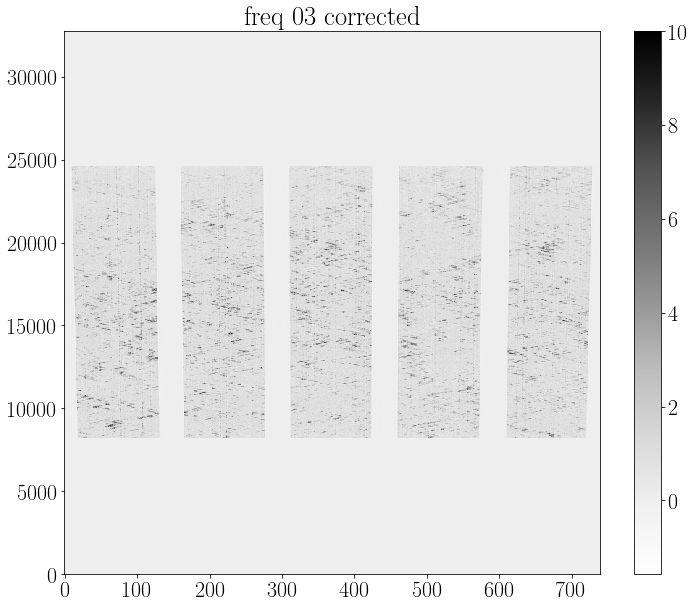

In [3]:
i=3
fig = plt.figure(figsize=(12,10))
plt.imshow(np.real(data_257_norm_with_l[i])[:, 290:1030], aspect='auto', origin='lower', cmap='Greys')
plt.colorbar()
plt.title('freq 0' + str(i) + ' corrected')
plt.show()

Now I can compute the flux curves, see get_flux.py

### If happy with these normalization steps

#### One can just upload the fluxcurves computed with the normalized (like above!) arrays and get_flux.py script

In [4]:
def get_fluxcurves_from_file(directory, baseline, freq, end):
    path = directory + baseline + 'freq' + freq + end
    return np.load(path)

In [5]:
freqs = ['00', '01', '02', '03']
fluxes257_normwithlambda3x001 = [get_fluxcurves_from_file('/mnt/scratch-lustre/bdesy/b0834/data/normalized_data/correct_channels/', '257', f, 'flux_norm_lambda3x001.npy') for f in freqs]

# Other stuff that can be used
#fluxes257_diffapertures = [get_fluxcurves_from_file('normalized_data/fluxes/', '257', f, '0.01step5.0-0.002.npy') for f in freqs]
#fluxes258 = [get_fluxcurves_from_file(d, '258', f) for f in freqs]
f_Ds = np.arange(-44, 44, 0.01)
a = (5.577e13)/(314.5e6)**2

We want to plot the arclets against $\Delta\theta$ to correct the frequency change. This change of axis is where the uncertainty in the measured position comes from because it uses the $V_{eff}$ that has errors

In [6]:
thetas_from_fD = [(( (f_Ds/1000) * l )/ Veff)*2.06265e8 for l in ls]

In [7]:
dtheta_faint00 = np.load('/mnt/scratch-lustre/bdesy/b0834/data/results/measurements/dtheta_position_arclets00_8rows.npy').reshape(8, -1)['position00']
dtheta_faint00_indices = [np.argmin(np.abs(dtheta_faint00[i] - thetas_from_fD[0])) for i in range(8)]
main_arclet_index = np.argmin(np.abs(-10.218 - thetas_from_fD[0]))

noise257s = np.mean(fluxes257_normwithlambda3x001[0][dtheta_faint00_indices[0]:dtheta_faint00_indices[-1]]) - np.std(fluxes257_normwithlambda3x001[0][dtheta_faint00_indices[0]:dtheta_faint00_indices[-1]])
start = main_arclet_index - 600
end = main_arclet_index + 500
noise_main257 = np.mean(fluxes257_normwithlambda3x001[0][start:end]) - np.std(fluxes257_normwithlambda3x001[0][start:end])


fluxes_faint00 = [fluxes257_normwithlambda3x001[0][dtheta_faint00_indices[i]]-noise257s for i in range(8)]
flux_main = fluxes257_normwithlambda3x001[0][main_arclet_index]-noise_main257
mu_over_mu_main = fluxes_faint00/flux_main  #saved in my /scratch-lustre/bdesy/b0834/data/results/measurements
ratio_main = 0.0484065160454  # best ratio for main arclet from SS, saved same place ratio_main257.txt
mu_over_mu_main, mu_over_mu_main*ratio_main

(array([ 0.02303403,  0.04252391,  0.02861362,  0.02154968,  0.02353288,
         0.02585785,  0.02570894,  0.01518578]),
 array([ 0.001115  ,  0.00205843,  0.00138509,  0.00104314,  0.00113914,
         0.00125169,  0.00124448,  0.00073509]))

Let's say that we have 10% error on all the ratios faint arclet to main, the error on the main arclet's ratio (21%) dominates but the fractional error goes up to 23%. 

In [8]:
ratio_main = 0.0484065160454
muim = np.array([ 0.02303403,  0.04252391,  0.02861362,  0.02154968,  0.02353288,
     0.02585785,  0.02570894,  0.01518578])
err_ratiom0 = 0.0101402008905/ratio_main
errs_muim = np.ones(muim.shape)*0.1
errs_mui0 = np.sqrt(err_ratiom0**2 + errs_muim**2)
print('ratio main arclet = {0} more or less {1}, i.e. {2:.4}%\n'.format(ratio_main, 0.0101402008905, 100*err_ratiom0))
for i in range(8):
    print('ratio of arclet {0} = {1} more or less {2}, i.e. {3:.4}%'.format(i, muim[i]*ratio_main, errs_mui0[i]*muim[i], 100*errs_mui0[i]))

ratio main arclet = 0.0484065160454 more or less 0.0101402008905, i.e. 20.95%

ratio of arclet 0 = 0.00111499714279 more or less 0.00534676868708, i.e. 23.21%
ratio of arclet 1 = 0.00205843433173 more or less 0.00987085240577, i.e. 23.21%
ratio of arclet 2 = 0.00138508565565 more or less 0.00664192967709, i.e. 23.21%
ratio of arclet 3 = 0.00104314493069 more or less 0.00500221429948, i.e. 23.21%
ratio of arclet 4 = 0.00113914473331 more or less 0.00546256412364, i.e. 23.21%
ratio of arclet 5 = 0.00125168843092 more or less 0.00600224722705, i.e. 23.21%
ratio of arclet 6 = 0.00124448021662 more or less 0.00596768152902, i.e. 23.21%
ratio of arclet 7 = 0.000735090703232 more or less 0.0035249955389, i.e. 23.21%


To plot fluxcurves etc

/opt/python/2.7.13/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


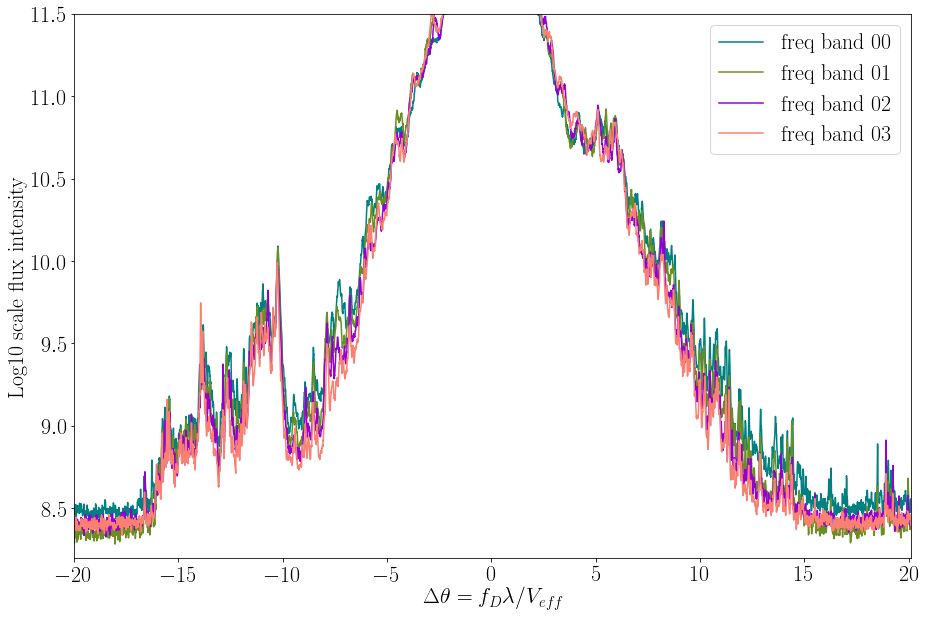

In [9]:
fig = plt.figure(figsize=(15,10))
colors = ['teal', 'olivedrab' , 'darkviolet', 'salmon']

for i in [0, 1, 2, 3]:
    #plt.plot(thetas_from_fD[i], np.log10(np.absolute(fluxes257_diffapertures[i])), c=colors[i], label=freqs[i], alpha=0.5)
    plt.plot(thetas_from_fD[0], np.log10(np.absolute(fluxes257_normwithlambda3x001[i])), c=colors[i], label='freq band '+freqs[i])

# To see noise baselines
#plt.axhline(y=np.log10(np.absolute(noise_main257)))    
#plt.axhline(y=np.log10(np.absolute(noise257s)))

# To check if values of fluxes are ok
#for i in range(8):
#    plt.plot(dtheta_faint00[i], np.log10(np.absolute(fluxes257_normwithlambda3x001[0][dtheta_faint00_indices[i]])), 'mo')
#plt.plot(thetas_from_fD[0][main_arclet_index], np.log10(np.absolute(fluxes257_normwithlambda3x001[0][main_arclet_index])), 'mo')

'''for xc in dtheta_faint00:
    plt.axvline(x=xc, color='darkcyan', linestyle='-', alpha=0.2)
plt.axvline(x=18.911, color='darkviolet', linestyle='-', alpha=0.2)
plt.axvline(x=19.248, color='darkviolet', linestyle='-', alpha=0.2)
plt.axvline(x=19.532, color='darkviolet', linestyle='-', alpha=0.2)
plt.axvline(x=19.969, color='olivedrab', linestyle='-', alpha=0.2)
plt.axvline(x=20.247, color='salmon', linestyle='-', alpha=0.2)
'''
#for xc in [19.02370,   19.02246 ,  19.02129 ,  19.02018, 19.14620 ,  19.14526 ,  19.14437 ,  19.14353]:
#    plt.axvline(x=xc, color='darkcyan', linestyle='-', alpha=0.2)

#for i in range(8):
#    plt.plot(dtheta_faint00[i], np.log10(np.absolute(fluxes_faint00[i])), 'mo', ms=6)

plt.xlabel(r"$\Delta\theta = f_D\lambda/V_{eff}$")
plt.ylabel("Log10 scale flux intensity")

#mesure = 20.247
#plt.axvline(x=mesure, color='m', linestyle='-', alpha=0.2)
#plt.axvline(x=mesure+0.005, color='b', linestyle='-', alpha=0.2)
#plt.axvline(x=mesure-0.005, color='b', linestyle='-', alpha=0.2)

#main = plt.axvline(-10.218, color='green')
#plt.plot(-10.218, np.log10(flux_main), 'co')

#plt.xticks(np.arange(-44, 44, 0.2))
plt.legend()
plt.ylim(8.2, 11.5)
plt.xlim( -20, 20.1)
plt.show()

Measured maxima on each frequency band precision of $\pm$ 0.005 mas, but limited by the limited precision from the transformation from $f_D$ to $\Delta\theta$ using $V_{eff}$.

In [199]:
# 8 arclets brightest on freq 00, not perceivable in freq 03
save = False
if save:
    ids = np.array(['000', '001', '002', '003', '004', '005', '006', '007'])
    theta00 = np.array([16.2775, 18.5079, 19.0237, 19.1462, 20.345, 22.003, 22.601, 24.733])
    theta01 = np.array([16.262, 18.495, 19.011, 19.139, 20.333, 21.989, 22.593, 24.725])
    theta02 = np.array([np.nan, 18.462, 18.995, 19.126, 20.324, 21.976, np.nan, 24.712])

    measured_position_arclets00 = np.rec.fromarrays((ids, theta00, theta01, theta02), names=('id', 'position00', 'position01', 'position02'))
    measured_position_arclets00

In [191]:
# 5 arclets that are brighter in other frequency bands, 2 first digits of id indicates which one
save = False
if save:
    ids = np.array(['020', '021', '022', '010', '030'])
    theta00 = np.array([18.935, 19.268, 19.539, 19.978, 20.278])
    theta01 = np.array([18.921, 19.254, 19.539, 19.969, 20.271])
    theta02 = np.array([18.911, 19.248, 19.532, 19.957, 20.256])
    theta03 = np.array([18.902, 19.234, 19.522, 19.946, 20.247])

    measured_position_other_arclets = np.rec.fromarrays((ids, theta00, theta01, theta02, theta03), names=('id', 'position00', 'position01', 'position02', 'position03'))
    measured_position_other_arclets

rec.array([('020',  18.935,  18.921,  18.911,  18.902),
 ('021',  19.268,  19.254,  19.248,  19.234),
 ('022',  19.539,  19.539,  19.532,  19.522),
 ('010',  19.978,  19.969,  19.957,  19.946),
 ('030',  20.278,  20.271,  20.256,  20.247)], 
          dtype=[('id', 'S3'), ('position00', '<f8'), ('position01', '<f8'), ('position02', '<f8'), ('position03', '<f8')])

For the errors on the position, we simply add up out measurement error or 0.0005 mas / measured separation to the fractionnal error on  $V_{eff}$, but here the error on $V_{eff}$ widely dominates.

In [33]:
measured_dtheta_00 = np.array([16.2775, 18.5079, 19.0237, 19.1462, 20.345, 22.003, 22.601, 24.733])
err_dtheta = np.sqrt((0.0005/measured_dtheta_00)**2 +  err_Veff**2)
err_dtheta, err_Veff

(array([ 0.00983611,  0.0098361 ,  0.0098361 ,  0.0098361 ,  0.0098361 ,
         0.00983609,  0.00983609,  0.00983609]), 0.009836065573770493)

For comparison between measurements and predicitons see 17_predicitons_Fold_object.ipynb